In [1]:
import numpy as np
import pandas as pd
import h5py
import math
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap as cmap
import pygbrowse

import scanpy as sc
import scvelo as scv
from sklearn.neighbors import NearestNeighbors
from harmony import harmonize

from scipy import stats
from tqdm.notebook import tqdm
import ipywidgets
from scipy.ndimage import gaussian_filter
from scipy.signal import gaussian, fftconvolve
from math import ceil, floor

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu 

### Functions

In [2]:
def get_colors_hex(n, colormap='viridis'):
    import matplotlib.colors as mcolors
    cmap = plt.get_cmap(colormap)
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]
    return colors

### Plot settings

In [3]:
COLORS = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# presentation style
plt.matplotlib.rcParams['font.weight'] = 'normal'
plt.matplotlib.rcParams['axes.titleweight'] = 'normal'
plt.matplotlib.rcParams['axes.facecolor'] = plt.matplotlib.colors.to_hex((1., 1., 1., 1.), keep_alpha=True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = .25

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

OUTDIR = '/Users/prullens/Documents/manuscripts/invivo/figure4/'

### Global variables

In [4]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]

CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5'

chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMIDFN_BASE = '/Users/prullens/Documents/projects/invivo/experiments/{}/hdf5/{}.index{:02d}.DamID2_BC_{:03d}.top_n_2.event_counts.binsize_{}.hdf5'

### Data

In [5]:
gtf = pd.read_csv('/Users/prullens/metadata/mm10.Mus_musculus.GRCm38.89.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')
gtf['gene_length'] = np.diff(gtf[['Start','End']], axis=1)

_Scanpy_

In [7]:
adata = sc.read_h5ad('/Users/prullens/data/projects/invivo/singlecell_lads_mouse_cortex.h5ad.gz')

adata

AnnData object with n_obs × n_vars = 5612 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    uns: 'cell_type_colors', 'construct_colors', 'construct_flattened_colors', 'embryo_colors', 'iue_colors', 'leiden_colors', 'limsid_colors', 'neighbors', 'rank_genes_groups', 'rank_genes_groups_cell_type'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distanc

_dyn-i/LAD genes_

In [8]:
gene_class = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20241108.ilad_lad_genes_activating_deactivating_balanced.tsv', sep='\t')

gene_class.shape

(677, 6)

In [45]:
ilad_var_names = gene_class.loc[gene_class['class'] == 'iLAD','Gene']
ilad_var_ids = gene_class.loc[gene_class['class'] == 'iLAD','Accession']
lad_var_names = gene_class.loc[gene_class['class'] == 'LAD','Gene']
lad_var_ids = gene_class.loc[gene_class['class'] == 'LAD','Accession']

_DamID_

In [9]:
binsize = 100_000

hdf5_list = [DAMIDFN_BASE.format(limsid,limsid,int(i),int(bc),binsize) 
             for limsid,i,bc in adata.obs[(adata.obs['damid'] == True) & 
                                          (adata.obs['construct_flattened'] == 'Dam-LMNB1')][
                 ['limsid','indexnr','damid2_barcodenr']].values
]

len(hdf5_list)

2423

In [10]:
oe_100kb, depths = scct.compute_oe(hdf5_list, 
                             100_000, 
                             CHROMSIZES, 
                             expected=EXPECTED %100_000, 
                             blacklist=BLACKLIST, 
                             chroms=CHROMS, 
)
len(oe_100kb)

  0%|          | 0/2423 [00:00<?, ?it/s]

2423

In [63]:
smooth_stddev = 150_000

oe_100kb_smooth = scct.gaussian_smoothing(oe_100kb, 100_000, smooth_stddev, False)

  0%|          | 0/2423 [00:00<?, ?it/s]

_____

In [12]:
fn = '/Users/prullens/Documents/projects/ESC/experiments/KIN6284/PR20241021.2b4_esc_damlb1_cf.binsize_100000.hdf5'
with h5py.File(fn, 'r') as f:
    cf_esc = {c: f[c][:] for c in CHROMS}

_Boxer et al., RNA-seq Mecp2 KO_

In [13]:
deseq_mecp2 = pd.read_csv('/Users/prullens/Documents/projects/invivo/experiments/GSE128186/PR20241021.GSE128186.mecp2_ko_rnaseq_deseq2.tsv', sep='\t')
deseq_mecp2['gene_name'] = gtf.loc[deseq_mecp2.index,'gene_name']
deseq_mecp2['chrom'] = gtf.loc[deseq_mecp2.index,'Chromosome']
deseq_mecp2 = deseq_mecp2[deseq_mecp2['chrom'].isin(CHROMS)].copy()
deseq_mecp2['gene_length'] = np.diff(gtf.loc[deseq_mecp2.index,['Start','End']].values, axis=1)
deseq_mecp2 = deseq_mecp2[(deseq_mecp2['gene_length'] >= 1_000) & (deseq_mecp2['gene_length'] <= 1_000_000)].copy()

deseq_mecp2.shape

(9074, 9)

_Boxer et al. MeCP2 (WT) ChIP-seq_

In [14]:
hdf5_list = sorted(glob('/Users/prullens/Documents/projects/invivo/experiments/GSE128186/counts/*binsize_1000.hdf5'))

binsize = 1_000

counts_chip_1kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS)

samples = ['Mecp2_WT_rep1','Mecp2_WT_rep2','Mecp2_WT_rep3','Mecp2_WT_rep4','input_WT']
counts_chip_1kb = {samples[i]: counts_chip_1kb[k] for i,k in enumerate(counts_chip_1kb)}

list(counts_chip_1kb)

  0%|          | 0/5 [00:00<?, ?it/s]

['Mecp2_WT_rep1',
 'Mecp2_WT_rep2',
 'Mecp2_WT_rep3',
 'Mecp2_WT_rep4',
 'input_WT']

In [15]:
oe_chip_1kb, _ = scct.compute_oe({k: counts_chip_1kb[k] for k in list(counts_chip_1kb)[:-1]},
                                 binsize, 
                                 CHROMSIZES, 
                                 expected=counts_chip_1kb['input_WT'], 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS, 
                                 disable_tqdm=True
)

len(oe_chip_1kb)

4

In [17]:
rebinsize = 100_000

counts_chip_100kb = scct.rebinning(counts_chip_1kb, binsize, rebinsize, chroms=CHROMS)

len(counts_chip_100kb)

5

In [18]:
oe_chip_100kb, _ = scct.compute_oe({k: counts_chip_100kb[k] for k in list(counts_chip_100kb)[:-1]},
                                 rebinsize, 
                                 CHROMSIZES, 
                                 expected=counts_chip_100kb['input_WT'], 
                                 blacklist=BLACKLIST, 
                                 chroms=CHROMS, 
                                 disable_tqdm=True
)

len(oe_chip_100kb)

4

In [19]:
oe_chip_1kb_mean = {c: np.mean([oe_chip_1kb[k][c] for k in list(oe_chip_1kb)[1:]], axis=0) for c in CHROMS}
oe_chip_100kb_mean = {c: np.mean([oe_chip_100kb[k][c] for k in list(oe_chip_100kb)[1:]], axis=0) for c in CHROMS}

_Boxer et al., BS-seq_

In [20]:
binsize = 1_000

samples = dict(zip(['CA','mCA','CG','mCG'],sorted(glob(f"/Users/prullens/data/projects/invivo/GSE128186/*{binsize}.sorted.bedGraph"))))

counts_bs = dict()
for sample in samples:
    fn = samples[sample]
    df = pd.read_csv(fn, sep='\t', header=None, low_memory=False)
    df = df[df[3] != '.']
    df['chrom'] = df[0].str.split('r').str[-1]
    df = df[df['chrom'].isin(CHROMS)]
    
    counts = {c: np.zeros((chromsizes[c]//binsize)+1) for c in CHROMS}
    for c,s,count in df[['chrom',1,3]].values:
        s //= binsize
        counts[c][s] = count
    counts_bs[sample] = counts
    print(sample)
    
bs_norm = {'mCA/CA':{c: counts_bs['mCA'][c] / (counts_bs['CA'][c]+1) for c in CHROMS}}
bs_norm['mCG/CG'] = {c: counts_bs['mCG'][c] / (counts_bs['CG'][c]+1) for c in CHROMS}

CA
mCA
CG
mCG


In [21]:
binsize = 1_000
rebinsize = 10_000

counts_bs_10kb = scct.rebinning(counts_bs, binsize, rebinsize, chroms=CHROMS)

bs_norm_10kb = {'mCA/CA':{c: counts_bs_10kb['mCA'][c] / (counts_bs_10kb['CA'][c]+1) for c in CHROMS}}
bs_norm_10kb['mCG/CG'] = {c: counts_bs_10kb['mCG'][c] / (counts_bs_10kb['CG'][c]+1) for c in CHROMS}

In [ ]:
binsize = 1_000
rebinsize = 10_000

counts_bs_10kb = scct.rebinning(counts_bs, binsize, rebinsize, chroms=CHROMS)

bs_norm_10kb = {'mCA/CA':{c: counts_bs_10kb['mCA'][c] / (counts_bs_10kb['CA'][c]+1) for c in CHROMS}}
bs_norm_10kb['mCG/CG'] = {c: counts_bs_10kb['mCG'][c] / (counts_bs_10kb['CG'][c]+1) for c in CHROMS}

In [74]:
binsize = 1_000
rebinsize = 100_000

counts_bs_100kb = scct.rebinning(counts_bs, binsize, rebinsize, chroms=CHROMS)

bs_norm_100kb = {'mCA/CA':{c: counts_bs_100kb['mCA'][c] / (counts_bs_100kb['CA'][c]+1) for c in CHROMS}}
bs_norm_100kb['mCG/CG'] = {c: counts_bs_100kb['mCG'][c] / (counts_bs_100kb['CG'][c]+1) for c in CHROMS}

In [82]:
bs_norm_100kb['mCA/CA_w'] = {c: counts_bs_100kb['mCA'][c] / (counts_bs_100kb['CA'][c]+1) * 
                          (dn_counts_100kb['CA'][c] / 100_000) for c in CHROMS}
bs_norm_100kb['mCG/CG_w'] = {c: counts_bs_100kb['mCG'][c] / (counts_bs_100kb['CG'][c]+1) * 
                          (dn_counts_100kb['CG'][c] / 100_000) for c in CHROMS}

In [114]:
binsize = 100_000
dinucleotides = ['CA','CG']

bs_dn_norm_100kb = {dn: {c: counts_bs_100kb[dn][c] / binsize for c in CHROMS} for dn in dinucleotides}

_nucleotide content_

In [22]:
binsize = 10_000
fn = f"/Users/prullens/metadata/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.nucleotide_content_ACGTN.binsize_{binsize}.hdf5"
with h5py.File(fn, 'r') as f:
    nucleotide_content_10kb = {c: f[c][:] for c in CHROMS}

In [23]:
at_content_10kb = {c: nucleotide_content_10kb[c][[0,3]].sum(0) / nucleotide_content_10kb[c].sum(0) for c in CHROMS}
gc_content_10kb = {c: nucleotide_content_10kb[c][[1,2]].sum(0) / nucleotide_content_10kb[c].sum(0) for c in CHROMS}

In [24]:
binsize = 100_000
fn = '/Users/prullens/metadata/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.nucleotide_content_ACGTN.binsize_100000.hdf5'
with h5py.File(fn, 'r') as f:
    nucleotide_content_100kb = {c: f[c][:] for c in CHROMS}

In [25]:
at_content_100kb = {c: nucleotide_content_100kb[c][[0,3]].sum(0) / nucleotide_content_100kb[c].sum(0) for c in CHROMS}
gc_content_100kb = {c: nucleotide_content_100kb[c][[1,2]].sum(0) / nucleotide_content_100kb[c].sum(0) for c in CHROMS}

_dinucleotides_

In [26]:
binsize = 10_000

hdf5_list = glob(f"/Users/prullens/metadata/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.dinucleotide_*.binsize_{binsize}.hdf5")
dn_counts_10kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, disable_tqdm=True)

dn_counts_10kb = {k.split('.')[-3].split('_')[1]: dn_counts_10kb[k] for k in dn_counts_10kb}

list(dn_counts_10kb)

['TT',
 'TC',
 'GT',
 'GC',
 'AT',
 'AC',
 'CC',
 'CT',
 'AG',
 'CG',
 'TG',
 'GG',
 'GA',
 'TA',
 'CA',
 'AA']

In [27]:
dn_norm_10kb = {k: {c: dn_counts_10kb[k][c] / binsize for c in CHROMS} for k in dn_counts_10kb}

In [28]:
binsize = 100_000

hdf5_list = glob(f"/Users/prullens/metadata/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.dinucleotide_*.binsize_{binsize}.hdf5")
dn_counts_100kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, disable_tqdm=True)

dn_counts_100kb = {k.split('.')[-3].split('_')[1]: dn_counts_100kb[k] for k in dn_counts_100kb}

list(dn_counts_100kb)

['AT',
 'AG',
 'AA',
 'AC',
 'TC',
 'TA',
 'TG',
 'TT',
 'CA',
 'CC',
 'CT',
 'CG',
 'GC',
 'GA',
 'GG',
 'GT']

In [29]:
dn_norm_100kb = {k: {c: dn_counts_100kb[k][c] / binsize for c in CHROMS} for k in dn_counts_100kb}

_MeCP2-Dam126_

In [30]:
binsize = 1_000
hdf5_list = sorted(glob('/Users/prullens/Documents/projects/invivo/experiments/KIN10808/hdf5/*.CAGMECP2Dam126.*.binsize_1000.hdf5'))

mecp2dam126_counts_1kb, depths = scct.load_counts(hdf5_list, 
                                                  binsize, 
                                                  CHROMSIZES, 
                                                  chroms=CHROMS
)
labels = ['MeCP2_Dam126_all',
          'MeCP2_Dam126_CThPN',
          'MeCP2_Dam126_SCPN',
          'MeCP2_Dam126_apical_progenitors',
          'MeCP2_Dam126_intermediate_progenitors',
          'MeCP2_Dam126_migrating_neurons'
]
mecp2dam126_counts_1kb = {labels[i]: mecp2dam126_counts_1kb[k] for i,k in enumerate(mecp2dam126_counts_1kb)}

list(mecp2dam126_counts_1kb)

  0%|          | 0/6 [00:00<?, ?it/s]

['MeCP2_Dam126_all',
 'MeCP2_Dam126_CThPN',
 'MeCP2_Dam126_SCPN',
 'MeCP2_Dam126_apical_progenitors',
 'MeCP2_Dam126_intermediate_progenitors',
 'MeCP2_Dam126_migrating_neurons']

In [32]:
rebinsize = 100_000

mecp2dam126_counts_100kb = scct.rebinning(mecp2dam126_counts_1kb, 1_000, rebinsize, chroms=CHROMS)

len(mecp2dam126_counts_100kb)

6

In [33]:
mecp2dam126_oe_100kb, _ = scct.compute_oe(mecp2dam126_counts_100kb, 
                                        rebinsize, 
                                        CHROMSIZES, 
                                        expected=EXPECTED %rebinsize, 
                                        blacklist=BLACKLIST, 
                                        chroms=CHROMS, 
                                        disable_tqdm=True
)
len(mecp2dam126_oe_100kb)

6

_LAD types_

In [34]:
mn_coord = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20250210.esc_vs_migrating_neurons.delta_cf.migrating_neurons_specific_lads.tsv', sep='\t', header=None)
esc_coord = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20250210.esc_vs_migrating_neurons.delta_cf.esc_specific_lads.tsv', sep='\t', header=None)
invariant_coord = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20250210.esc_vs_migrating_neurons.delta_cf.invariant_specific_lads.tsv', sep='\t', header=None)

mn_coord.shape, esc_coord.shape, invariant_coord.shape

((578, 3), (241, 3), (365, 3))

In [35]:
esc_lads = {c: np.zeros((chromsizes[c]//100_000)+1, dtype=int) for c in CHROMS}
for c,s,e in esc_coord.values:
    s_bin = s // 100_000
    e_bin = e // 100_000
    esc_lads[c][s_bin:e_bin] = 1
    
mn_lads = {c: np.zeros((chromsizes[c]//100_000)+1, dtype=int) for c in CHROMS}
for c,s,e in mn_coord.values:
    s_bin = s // 100_000
    e_bin = e // 100_000
    mn_lads[c][s_bin:e_bin] = 1
    
invariant_lads = {c: np.zeros((chromsizes[c]//100_000)+1, dtype=int) for c in CHROMS}
for c,s,e in invariant_coord.values:
    s_bin = s // 100_000
    e_bin = e // 100_000
    invariant_lads[c][s_bin:e_bin] = 1
    
invariant_lads = {c: (~mn_lads[c]) & (~esc_lads[c]) & (invariant_lads[c]) for c in CHROMS}

_Hahn et al., 5mC MIRA-seq_

In [36]:
binsize = 10_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.mira_5mc*.binsize_{binsize}.hdf5'))

m5c_10kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
m5c_10kb = {labels[i]: m5c_10kb[k] for i,k in enumerate(m5c_10kb)}

list(m5c_10kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

In [89]:
binsize = 100_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.mira_5mc*.binsize_{binsize}.hdf5'))

m5c_100kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
m5c_100kb = {labels[i]: m5c_100kb[k] for i,k in enumerate(m5c_100kb)}

list(m5c_100kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

_Hahn et al., 5hmC hMeDip_

In [37]:
binsize = 10_000

hdf5_list =  sorted(glob(f'/Users/prullens/Documents/projects/invivo/experiments/GSE38118/hdf5/GSE38118.hmedip_5hmc_*.binsize_{binsize}.hdf5'))

h5mc_10kb, _ = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS, dtype=np.float32)

labels = ['neurons',
          'npc',
]
h5mc_10kb = {labels[i]: h5mc_10kb[k] for i,k in enumerate(h5mc_10kb)}

list(h5mc_10kb)

  0%|          | 0/2 [00:00<?, ?it/s]

['neurons', 'npc']

### Plot

In [38]:
adata.uns['cell_type_colors'] = np.array(['#1B7837', #PN1
                                          '#00441B',#PN2
                                          '#053061', #apical_progenitors
                                       '#4393C3', #intermediate_progenitors
                                       '#2020DF', #interneurons
                                       '#AFA5CF', #migrating_neurons
                                       '#543005'], #red_blood_cells
                                      dtype=object
)

In [39]:
color_dict = {'All':COLORS[0],'iLAD':COLORS[1],'LAD':COLORS[2]}

color_dict

{'All': '#1f77b4', 'iLAD': '#ff7f0e', 'LAD': '#2ca02c'}

In [70]:
cell_type_colors = dict(zip(adata.obs['cell_type'].cat.categories,adata.uns['cell_type_colors']))
cell_type_colors['esc'] = COLORS[8]
cell_type_colors['excitatory_neurons'] = '#1B7837'

cell_type_colors

{'PN1': '#1B7837',
 'PN2': '#00441B',
 'apical_progenitors': '#053061',
 'intermediate_progenitors': '#4393C3',
 'interneurons': '#2020DF',
 'migrating_neurons': '#AFA5CF',
 'red_blood_cells': '#543005',
 'esc': '#bcbd22',
 'excitatory_neurons': '#1B7837'}

In [41]:
cell_types = ['apical_progenitors','intermediate_progenitors','migrating_neurons','PN1','PN2']

cell_types, len(cell_types)

(['apical_progenitors',
  'intermediate_progenitors',
  'migrating_neurons',
  'PN1',
  'PN2'],
 5)

In [67]:
cf_dict_100kb = dict()
for cell_type in cell_types + ['interneurons','red_blood_cells']:
    obs_names = adata.obs[np.ravel(adata.obs['damid']) &
                (adata.obs['cell_type'] == cell_type) & 
                (adata.obs['construct_flattened'] == 'Dam-LMNB1')].index
    cf_dict_100kb[cell_type] = {c: np.mean([oe_100kb_smooth[obs][c] > 1 for obs in obs_names], axis=0) for c in CHROMS}
    
cf_dict_100kb['esc'] = cf_esc

list(cf_dict_100kb)

['apical_progenitors',
 'intermediate_progenitors',
 'migrating_neurons',
 'PN1',
 'PN2',
 'interneurons',
 'red_blood_cells',
 'esc']

____

____

### dyn-i/LAD gene length

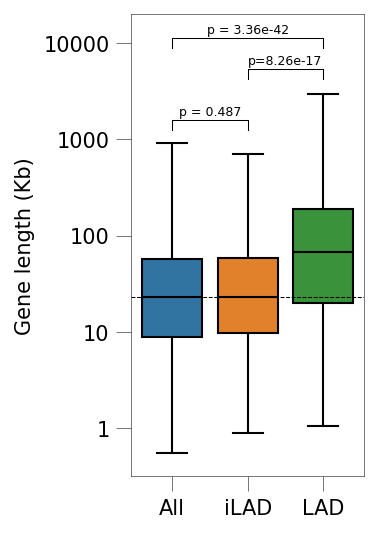

In [48]:
X = np.r_[np.repeat('All',adata.shape[1]),
          np.repeat('iLAD',ilad_var_names.size),
          np.repeat('LAD',lad_var_names.size)
]
y = np.log10(np.r_[np.ravel(np.diff(adata.var[['Start','End']], axis=1)),
                   np.ravel(np.diff(adata.var.loc[ilad_var_names,['Start','End']], axis=1)),
          np.ravel(np.diff(adata.var.loc[lad_var_names,['Start','End']], axis=1))
])

f, ax = plt.subplots(figsize=(2,4))

sns.boxplot(x=X, y=y, fliersize=0, palette=COLORS, linecolor='k')

ax.set_yticks(np.arange(3,8,1))
ax.set_yticklabels((10**np.arange(3,8,1) / 1_000).astype(int))
ax.set_ylabel('Gene length (Kb)')


ymin, ymax = 2.5, 7.3
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='All'],y[X=='iLAD'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 1.2, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest iLAD vs LAD
p = stats.ttest_ind(y[X=='iLAD'],y[X=='LAD'])[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - .675, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p={p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest All vs LAD
p = stats.ttest_ind(y[X=='All'],y[X=='LAD'])[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - .35, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

ax.axhline(np.median(y[X=='All']), lw=.5, ls='--', color='k', zorder=10)

### General LAD protein coding gene length

In [64]:
gtf_sub = gtf[(gtf['gene_biotype'] == 'protein_coding') & (gtf['Chromosome'].isin(CHROMS))].copy()
gtf_sub = gtf_sub[gtf_sub['gene_length'] >= 500]

X = list()
y = list()
cf = list()
for c,tss,gene_length in gtf_sub[['Chromosome','tss','gene_length']].values:
    tss_bin = tss // 100_000 
    
    for cell_type in ['esc'] + cell_types:
        X.append(cell_type)
        y.append(gene_length)
        cf.append(cf_dict_100kb[cell_type][c][tss_bin])
X = np.array(X)
y = np.log10(y)
cf = np.array(cf)

cf_thrs = 0.20
hue = np.zeros(len(cf), dtype=object)
hue[cf < cf_thrs] = 'iLAD'
hue[cf >= cf_thrs] = 'LAD'
    
len(X), len(y), len(cf), len(hue)

(129246, 129246, 129246, 129246)

Text(0.5, 1.0, 'All protein coding genes')

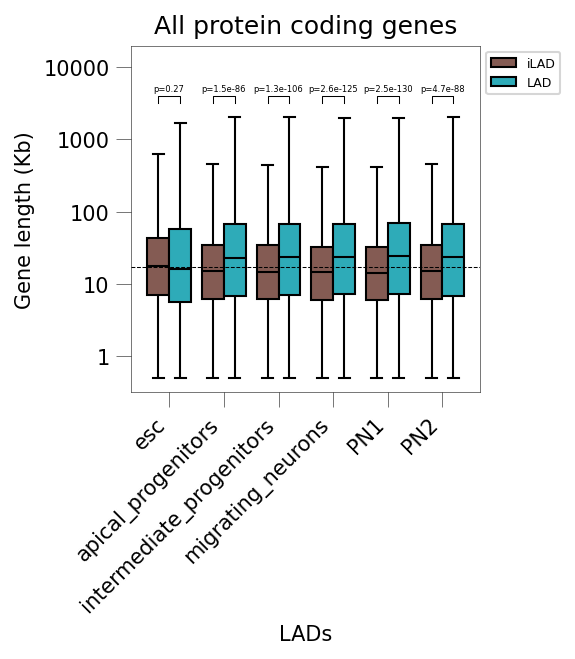

In [65]:
f, ax = plt.subplots(figsize=(3,3))

sns.boxplot(x=X, y=y, hue=hue, palette=[COLORS[5], COLORS[-1]], fliersize=0, linecolor='k')

ymax = 7.3
ax.set_ylim(top=ymax)
for i,cell_type in enumerate(['esc'] + cell_types):
    p = stats.ttest_ind(y[(X == cell_type) & (hue == 'iLAD')], y[(X == cell_type) & (hue == 'LAD')])[1]
    x1, x2 = i - .2, i + .2
    y0, h = ymax - .8, .1
    ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
    ax.text((x1+x2)*.5, y0+h+.04, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=4)

ax.axhline(np.median(y), lw=.5, ls='--', color='k', zorder=10)

ax.set_xticklabels(['esc'] + cell_types, rotation=45, ha='right')
ax.set_xlabel('LADs')
ax.set_ylabel('Gene length (Kb)')
ax.set_yticks(np.arange(3,8,1))
ax.set_yticklabels((10**np.arange(3,8,1) / 1_000).astype(int))
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))
ax.set_title('All protein coding genes')

Text(0.5, 1.0, 'All protein coding genes')

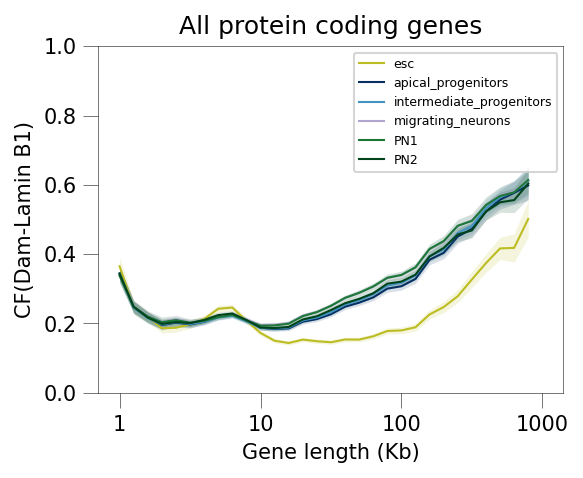

In [71]:
gene_ids = gtf[(gtf['gene_biotype'] == 'protein_coding') & 
               (gtf['Chromosome'].isin(CHROMS)) & 
               (gtf['gene_length'] >= 1_000) & 
               (gtf['gene_length'] <= 1_000_000)].index

f, ax = plt.subplots(figsize=(4,3))

X = np.log10(gtf.loc[gene_ids,'gene_length'].values)
for cell_type in ['esc'] + cell_types:
    
    y = np.zeros(gene_ids.size)
    for i,(c,tss) in enumerate(gtf.loc[gene_ids,['Chromosome','tss']].values):
        tss_bin = tss // 100_000
        y[i] = cf_dict_100kb[cell_type][c][tss_bin]

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=y, 
                                    _RADIUS=.05, 
                                    step=.1
    )

    ax.plot(xhat, 
            yhat, 
            color=cell_type_colors[cell_type],
            label=cell_type,
            lw=1
    )
    ax.fill_between(xhat, 
                    yhat - yhat_sem, 
                    yhat + yhat_sem, 
                    color=cell_type_colors[cell_type],
                    alpha=.15,
                    lw=0
    )
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_xticks(range(3,7))
ax.set_xticklabels(10**np.arange(3,7) // 1_000)

ax.set_xlim(2.85, 6.15)
ax.set_xlabel('Gene length (Kb)')
ax.set_ylabel('CF(Dam-Lamin B1)')

ax.set_ylim(0,1)
ax.set_title('All protein coding genes')

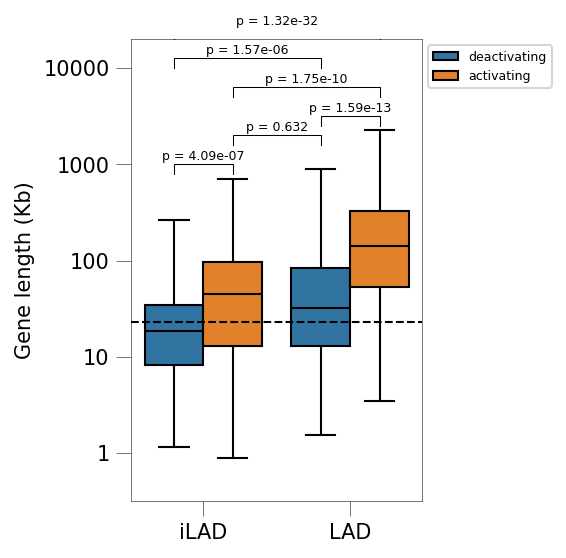

In [72]:
X = gene_class['class'].values
y = np.log10(gtf.loc[gene_class['Accession'],'gene_length'])
hue = gene_class['trend'].values

f, ax = plt.subplots(figsize=(2.5,4))

sns.boxplot(x=X, y=y, hue=hue, hue_order=['deactivating','activating'], fliersize=0, linecolor='k')

ax.axhline(np.median(np.log10(np.diff(adata.var[['Start','End']], axis=1))), lw=1, ls='--', color='k')

ax.set_yticks(np.arange(3,8,1))
ax.set_yticklabels((10**np.arange(3,8,1) / 1_000).astype(int))
ax.set_ylabel('Gene length (Kb)')


ymin, ymax = 2.5, 7.3
ax.set_ylim(ymin,ymax)

#ttest
p = stats.ttest_ind(y[(X=='iLAD') & (hue=='activating')], y[(X=='iLAD') & (hue=='deactivating')])[1]

#annotate
x1, x2 = -.2, .2
y0, h = ymax - 1.4, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest
p = stats.ttest_ind(y[(X=='LAD') & (hue=='activating')], y[(X=='LAD') & (hue=='deactivating')])[1]

#annotate
x1, x2 = .8, 1.2
y0, h = ymax - .9, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest
p = stats.ttest_ind(y[(X=='iLAD') & (hue=='activating')], y[(X=='LAD') & (hue=='deactivating')])[1]

#annotate
x1, x2 = .2, .8
y0, h = ymax - 1.1, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest
p = stats.ttest_ind(y[(X=='iLAD') & (hue=='activating')], y[(X=='LAD') & (hue=='activating')])[1]

#annotate
x1, x2 = .2, 1.2
y0, h = ymax - .6, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest
p = stats.ttest_ind(y[(X=='iLAD') & (hue=='deactivating')], y[(X=='LAD') & (hue=='deactivating')])[1]

#annotate
x1, x2 = -.2, .8
y0, h = ymax - .3, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

#ttest
p = stats.ttest_ind(y[(X=='iLAD') & (hue=='deactivating')], y[(X=='LAD') & (hue=='activating')])[1]

#annotate
x1, x2 = -.2, 1.2
y0, h = ymax - 0, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3}", ha='center', va='bottom', c='k', fontsize=6)

ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

### Neural specific LADs

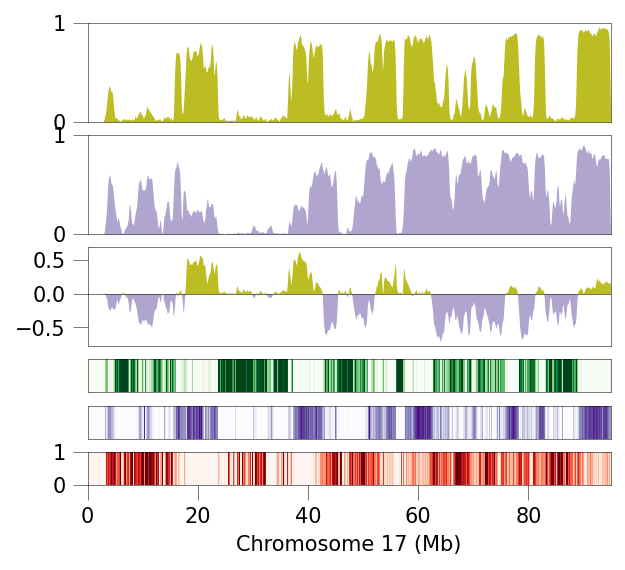

In [88]:
#smooth_stddev 125_000
chrom = '17'

binsize = 100_000
xaxis = np.arange(0,chromsizes[chrom],binsize) / 1e6

f, ax = plt.subplots(6, 1, figsize=(4.5,4), gridspec_kw={'height_ratios':[.6,.6,.6,.2,.2,.2]})

cell_type0 = 'esc'
y0 = cf_dict_100kb[cell_type0][chrom]
ax[0].fill_between(xaxis, y0, color=cell_type_colors[cell_type0], lw=0)

cell_type1 = 'migrating_neurons'
y1 = cf_dict_100kb[cell_type1][chrom]
ax[1].fill_between(xaxis, y1, color=cell_type_colors[cell_type1], lw=0)

X = (y0 - y1) 
X[X < 0] = 0
ax[2].fill_between(xaxis, 
                   X, 
                   lw=0,
                   color=cell_type_colors[cell_type0]
                  )
X = (y0 - y1) 
X[X > 0] = 0
ax[2].fill_between(xaxis, 
                   X, 
                   lw=0,
                   color=cell_type_colors[cell_type1]
                  )
ax[2].axhline(0, lw=.25, color='k')

k = 'CG'
X = dn_norm_100kb[k][chrom].reshape(1,-1)
p = np.percentile(X, 99.9)
X[X > p] = p
pcf1 = ax[3].pcolorfast(xaxis, 
                        [0,1], 
                        X, 
                        cmap='Greens', 
                        vmin=.006,
                        vmax=.013
)

X = at_content_100kb[chrom].reshape(1,-1)
p = np.percentile(X, 99.9)
X[X > p] = p
pcf1 = ax[4].pcolorfast(xaxis, 
                        [0,1], 
                        X, 
                        cmap='Purples', 
                        vmin=.55,
                        vmax=.65
)

k = 'mCA/CA_w'
X = bs_norm_100kb[k][chrom].reshape(1,-1)
p = np.percentile(X, 99.9)
X[X > p] = p
pcf1 = ax[5].pcolorfast(xaxis, 
                        [0,1], 
                        X, 
                        cmap='Reds', 
                        vmin=.002,
                        vmax=.0052
)

ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

ax[2].margins(x=0)

for i in [0,1]:
    ax[i].margins(x=0)
    ax[i].set_ylim(0,1)
    ax[i].set_yticks([0,1])
for i in range(ax.size-1):
    ax[i].set_xticks([])
for i in (3,4):
    ax[i].set_yticks([])

Text(0, 0.5, 'A/T content')

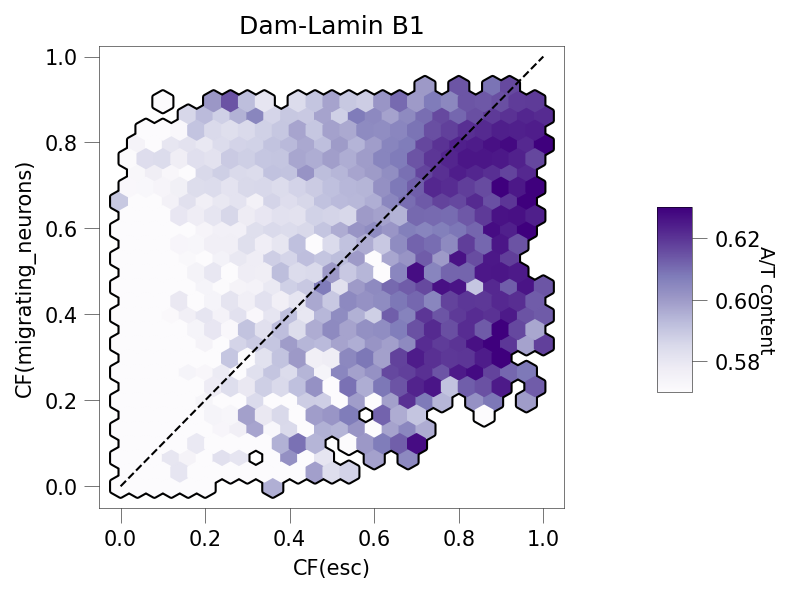

In [110]:
cell_type0 = 'esc'
cell_type1 = 'migrating_neurons'

X = np.hstack(list(cf_dict_100kb[cell_type0].values()))
y = np.hstack(list(cf_dict_100kb[cell_type1].values()))

c = np.hstack(list(at_content_100kb.values()))

f, ax = plt.subplots(figsize=(4,4))

hb = ax.hexbin(X, 
               y, 
               C=c, 
               gridsize=25, 
               mincnt=1, 
               lw=3,
               edgecolor='k',
               cmap='Reds', 
)

hb = ax.hexbin(X, 
               y, 
               C=c, 
               gridsize=25, 
               mincnt=1, 
               cmap='Purples',
               vmin=.57,
               vmax=.63
)

ax.plot([0,1],[0,1], lw=1, ls='--', color='k')
ax.set_ylim(top=1.025)

ax.set_title('Dam-Lamin B1')
ax.set_xlabel(f"CF({cell_type0})")
ax.set_ylabel(f"CF({cell_type1})")
# ax.set_xlim(-.05,1.05)
# ax.set_ylim(-.05,1.05)

axins = inset_axes(ax,
   width="5%",  # width = 5% of parent_bbox width
   height="40%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.2, .25, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(hb, ax=ax, cax=axins, pad=.06)
cbar.ax.set_ylabel('A/T content', labelpad=7, rotation=270, fontsize=9)

Text(0, 0.5, 'CpG density')

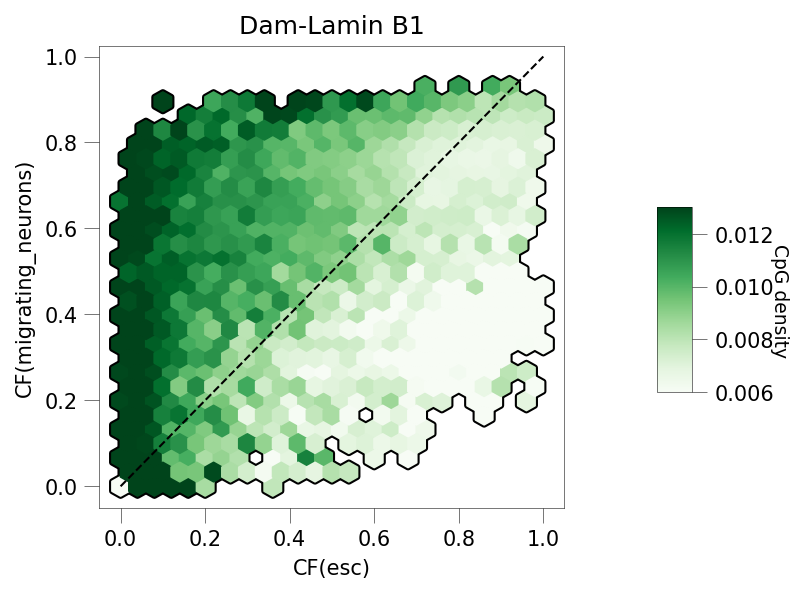

In [115]:
cell_type0 = 'esc'
cell_type1 = 'migrating_neurons'

X = np.hstack(list(cf_dict_100kb[cell_type0].values()))#[incl_idx]
y = np.hstack(list(cf_dict_100kb[cell_type1].values()))#[incl_idx]

dn = 'CG'
c = np.hstack(list(bs_dn_norm_100kb[dn].values()))##[incl_idx]
p = np.percentile(c, 99.9)
c[c > p] = p

f, ax = plt.subplots(figsize=(4,4))

hb = ax.hexbin(X, 
               y, 
               C=c, 
               gridsize=25, 
               mincnt=1, 
               lw=3,
               edgecolor='k',
               cmap='Reds', 
)

hb = ax.hexbin(X, 
               y, 
               C=c, 
               gridsize=25, 
               mincnt=1, 
               cmap='Greens',
               vmin=.006,
               vmax=.013
)

ax.plot([0,1],[0,1], lw=1, ls='--', color='k')
ax.set_ylim(top=1.025)

ax.set_title('Dam-Lamin B1')
ax.set_xlabel(f"CF({cell_type0})")
ax.set_ylabel(f"CF({cell_type1})")
# ax.set_xlim(-.05,1.05)
# ax.set_ylim(-.05,1.05)

axins = inset_axes(ax,
   width="5%",  # width = 5% of parent_bbox width
   height="40%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.2, .25, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(hb, ax=ax, cax=axins, pad=.06)
cbar.ax.set_ylabel('CpG density', labelpad=7, rotation=270, fontsize=9)

In [140]:
count_dict = dict()
for _class in ('iLAD','LAD'):
    gene_ids = gene_class.loc[gene_class['class'] == _class,'Accession'].values
    
    X = np.zeros((gene_ids.size,3)) #invariant,esc,mn-specific
    for i,(c,tss) in enumerate(gtf.loc[gene_ids,['Chromosome','tss']].values):
        tss_bin = tss // 100_000

        X[i,0] = invariant_lads[c][tss_bin]
        X[i,1] = esc_lads[c][tss_bin]
        X[i,2] = mn_lads[c][tss_bin]

    invariant_count = ((X[:,0] == 1) & (X[:,1:].sum(1) == 0)).sum()
    esc_count = X[:,1].sum()
    mn_count = X[:,2].sum()
    ilad_count = gene_ids.size - (invariant_count + esc_count + mn_count)
    
    count_dict[f"dyn-{_class}"] = (np.array([ilad_count,invariant_count,esc_count,mn_count]) / gene_ids.size) * 100

df = pd.DataFrame(count_dict, index=['ciLAD','cLAD','ESC-specific','MN-specific']).T

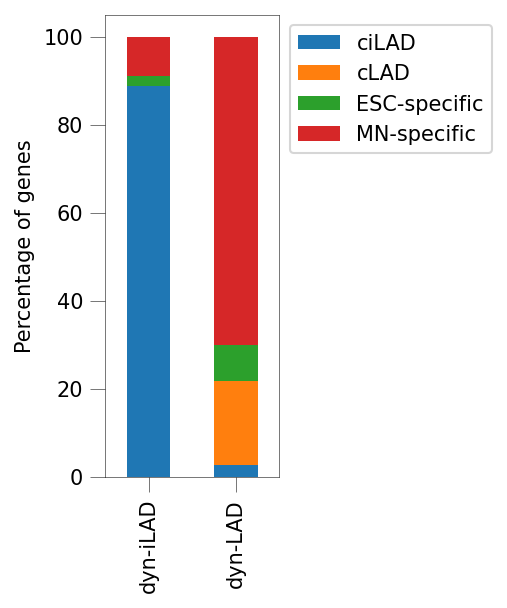

In [141]:
f, ax = plt.subplots(figsize=(1.5,4))

df.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Percentage of genes')
ax.legend(bbox_to_anchor=(1,1))

In [142]:
gtf_sub = gtf[(gtf['gene_biotype'] == 'protein_coding') & (gtf['Chromosome'].isin(CHROMS))].copy()
gtf_sub = gtf_sub[gtf_sub['gene_length'] >= 100_000]

X = np.zeros((gtf_sub.shape[0],3)) #invariant,esc,mn-specific
for i,(c,tss) in enumerate(gtf_sub[['Chromosome','tss']].values):
    tss_bin = tss // 100_000

    X[i,0] = invariant_lads[c][tss_bin]
    X[i,1] = esc_lads[c][tss_bin]
    X[i,2] = mn_lads[c][tss_bin]

invariant_count = ((X[:,0] == 1) & (X[:,1:].sum(1) == 0)).sum()
esc_count = X[:,1].sum()
mn_count = X[:,2].sum()
ilad_count = gtf_sub.shape[0] - (invariant_count + esc_count + mn_count)

counts = np.array([ilad_count, invariant_count, esc_count, mn_count]) #/ gtf_sub.shape[0]

df = pd.DataFrame(counts, index=['ciLAD','cLAD','ESC-specific','MN-specific']).T

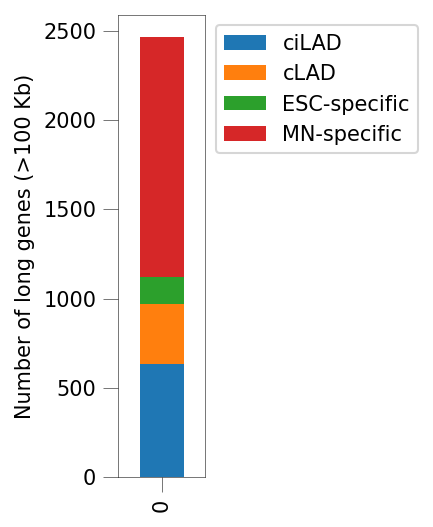

In [143]:
f, ax = plt.subplots(figsize=(.75,4))

df.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Number of long genes (>100 Kb)')
ax.legend(bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'npc')

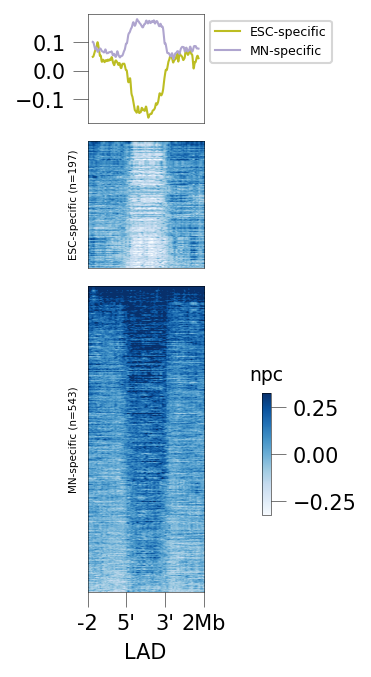

In [109]:
window = 2_000_000
sample = 'npc'
data = m5c_10kb[sample]

regions_dict = {
                'ESC-specific':esc_coord,
                'MN-specific':mn_coord
}
nregions = np.array([regions_dict[k].shape[0] for k in regions_dict])
height_ratios = np.r_[.25, nregions / nregions.sum()]

f, ax = plt.subplots(len(regions_dict) + 1, 
                     1, 
                     figsize=(1,5), 
                     gridspec_kw={'height_ratios':height_ratios,'hspace':.1}
)

for i,k in enumerate(regions_dict):
    regions = regions_dict[k]
    a2d, bounds = scct.scale_regions(regions, data, 10_000, window)
    a2d = gaussian_filter(a2d[bounds], 3)
    p = np.percentile(a2d,99)
    a2d[a2d > p] = p

    pad = a2d.shape[1] // 3
    argsort = np.argsort(a2d[:,pad:pad*2].mean(1))
    argsort = np.argsort(a2d.mean(1))
    a2d = a2d[argsort][30:]
    
    ax[0].plot(a2d.mean(0), 
               lw=1,
               label=k,
               color=cell_type_colors[['esc','migrating_neurons'][i]]
    )
    im = ax[i+1].imshow(a2d, 
                 aspect='auto', 
                 origin='lower', 
                 cmap='Blues',
                 vmin=-.325,
                 vmax=.325
    )
    if i < len(regions_dict):
        ax[i].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_ylabel(f'{k} (n={a2d.shape[0]})', fontsize=5)
        
ax[-1].set_xticks(np.arange(0,pad*4,pad),[-2,"5'","3'",'2Mb'])
ax[-1].set_xlabel('LAD')
ax[0].legend(prop={'size':6}, bbox_to_anchor=(1,1))

axins = inset_axes(ax[-1],
   width="5%",  # width = 5% of parent_bbox width
   height="40%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.5, .25, 1.5, 1),
   bbox_transform=ax[-1].transAxes,
   borderpad=0,
   )
cbar = f.colorbar(im, ax=ax[-1], cax=axins)
cbar.ax.set_title(f'{sample}', fontsize=9)

In [144]:
adata

AnnData object with n_obs × n_vars = 5612 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    uns: 'cell_type_colors', 'construct_colors', 'construct_flattened_colors', 'embryo_colors', 'iue_colors', 'leiden_colors', 'limsid_colors', 'neighbors', 'rank_genes_groups', 'rank_genes_groups_cell_type'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distanc

### MeCP2

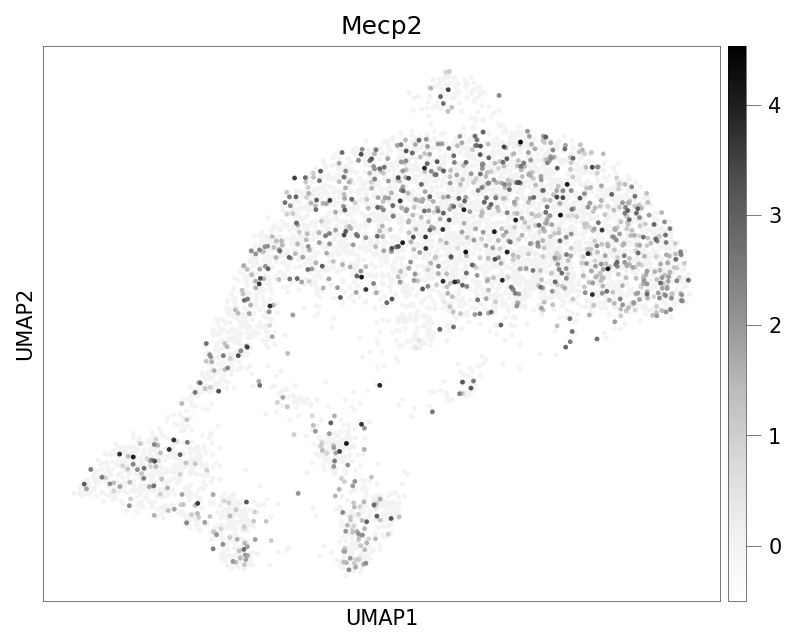

In [153]:
sc.pl.umap(adata, 
            color='Mecp2',
            cmap='Greys',
            vmin=-.5,
            layer='count_abundance_genes_from_celseq2_data',
)

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

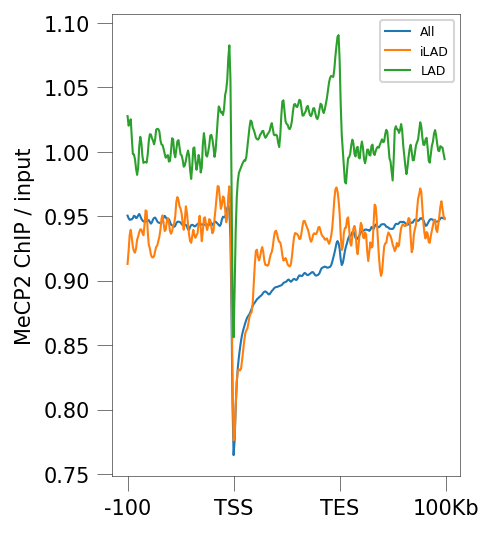

In [124]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4))

labels = ['All','iLAD','LAD']
for i,gene_ids in enumerate([deseq_mecp2.index,ilad_var_ids,lad_var_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, oe_chip_1kb_mean, 1_000, window, strand=strand)
    a2d = gaussian_filter(a2d[bounds], sigma=1)
    
    
    ax.plot(a2d.mean(0), color=COLORS[i], lw=1, label=f"{labels[i]}")
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel('MeCP2 ChIP / input')
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

In [125]:
ilad_var_ids_mecp2 = ilad_var_ids[ilad_var_ids.isin(deseq_mecp2.index)]
lad_var_ids_mecp2 = lad_var_ids[lad_var_ids.isin(deseq_mecp2.index)]

ilad_var_ids_mecp2.size, lad_var_ids_mecp2.size

(202, 246)

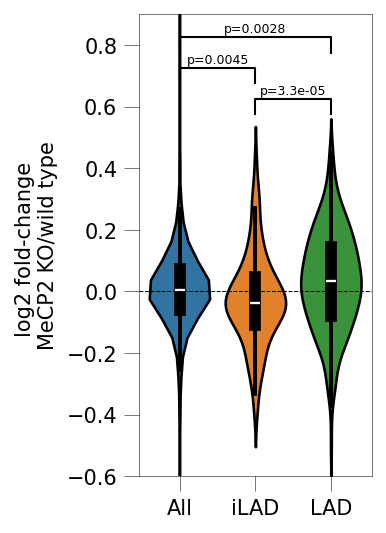

In [127]:
X = np.r_[np.repeat('All',deseq_mecp2.shape[0]),
          np.repeat('iLAD',ilad_var_ids_mecp2.size),
          np.repeat('LAD',lad_var_ids_mecp2.size),
]
y = np.r_[deseq_mecp2['log2FoldChange'].values,
          deseq_mecp2.loc[ilad_var_ids_mecp2,'log2FoldChange'].values,
          deseq_mecp2.loc[lad_var_ids_mecp2,'log2FoldChange'].values,
]

f, ax = plt.subplots(figsize=(2,4))

sns.violinplot(x=X, 
            y=y, 
            palette=list(COLORS[:3]),  
               edgecolor='k'
)

ymin, ymax = -.6, .9
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='All'],y[X=='iLAD'], equal_var=False)[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - .225, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest iLAD vs LAD
p = stats.ttest_ind(y[X=='iLAD'],y[X=='LAD'], equal_var=False)[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - .325, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest All vs LAD
p = stats.ttest_ind(y[X=='All'],y[X=='LAD'], equal_var=False)[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - .125, .05
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

ax.set_ylabel('log2 fold-change \nMeCP2 KO/wild type')

ax.axhline(0, lw=.5, ls='--', color='k', zorder=10)

In [149]:
mecp2_up_gene_ids = deseq_mecp2[(deseq_mecp2['log2FoldChange'] > .1) & (deseq_mecp2['pvalue'] < 0.05)].index
mecp2_down_gene_ids = deseq_mecp2[(deseq_mecp2['log2FoldChange'] < -.1) & (deseq_mecp2['pvalue'] < 0.05)].index
mecp2_unaffected_gene_ids = deseq_mecp2.loc[(deseq_mecp2['pvalue'] > 0.05) & 
                                (deseq_mecp2['log2FoldChange'] < .1) & 
                                (deseq_mecp2['log2FoldChange'] > -.1)
].index

mecp2_up_gene_ids.size, mecp2_down_gene_ids.size, mecp2_unaffected_gene_ids.size

(1370, 1233, 5494)

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

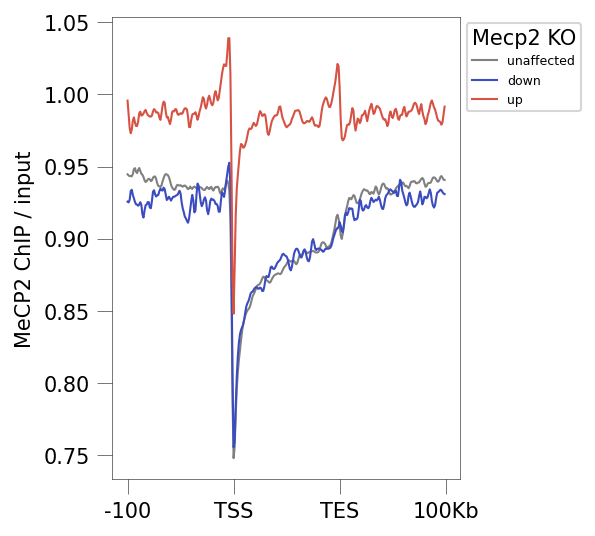

In [150]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4))

labels = ['unaffected','down','up']
for i,gene_ids in enumerate([mecp2_unaffected_gene_ids,mecp2_down_gene_ids,mecp2_up_gene_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, oe_chip_1kb_mean, 1_000, window, strand=strand)
    a2d = gaussian_filter(a2d[bounds], sigma=1)
    
    
    ax.plot(a2d.mean(0), color=['grey','#3b4cc0','#d65244'][i], lw=1, label=f"{labels[i]}")
    
ax.legend(title='Mecp2 KO', prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel('MeCP2 ChIP / input')
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])

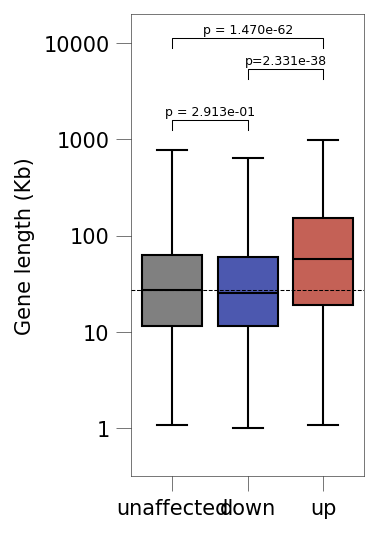

In [151]:
X = np.r_[np.repeat('unaffected',mecp2_unaffected_gene_ids.size),
          np.repeat('down',mecp2_down_gene_ids.size),
          np.repeat('up',mecp2_up_gene_ids.size)
]
y = np.log10(np.r_[deseq_mecp2.loc[mecp2_unaffected_gene_ids,'gene_length'],
                   deseq_mecp2.loc[mecp2_down_gene_ids,'gene_length'],
                   deseq_mecp2.loc[mecp2_up_gene_ids,'gene_length']
])

f, ax = plt.subplots(figsize=(2,4))

sns.boxplot(x=X, y=y, fliersize=0, palette=['grey','#3b4cc0','#d65244'], linecolor='k')

ax.set_yticks(np.arange(3,8,1))
ax.set_yticklabels((10**np.arange(3,8,1) / 1_000).astype(int))
ax.set_ylabel('Gene length (Kb)')


ymin, ymax = 2.5, 7.3
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='unaffected'],y[X=='down'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 1.2, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=6)

#ttest iLAD vs LAD
p = stats.ttest_ind(y[X=='down'],y[X=='up'])[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - .675, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p={p:.3e}", ha='center', va='bottom', c='k', fontsize=6)

#ttest All vs LAD
p = stats.ttest_ind(y[X=='unaffected'],y[X=='up'])[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - .35, .1
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=.5, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=6)

ax.axhline(np.median(y[X=='unaffected']), lw=.5, ls='--', color='k', zorder=10)

### Venn diagram

In [132]:
from matplotlib_venn import venn2, venn3

In [133]:
var_ids_intersect = np.intersect1d(deseq_mecp2.index,adata.var['Accession'])

var_ids_intersect.size

7804

In [134]:
long_var_ids = deseq_mecp2[deseq_mecp2['gene_length'] > 100_000].index
long_var_ids = np.intersect1d(long_var_ids,var_ids_intersect)

long_var_ids.size

1307

In [135]:
#Mecp2 targets
up_mecp2_var_ids = deseq_mecp2.loc[(deseq_mecp2['log2FoldChange'] > 0.1) & (deseq_mecp2['pvalue'] < 0.05)].index
up_mecp2_var_ids = np.intersect1d(up_mecp2_var_ids, var_ids_intersect)

up_mecp2_var_ids.size

1108

In [136]:
#LAD and iLAD genes
ilad_var_ids_mecp2 = ilad_var_ids[ilad_var_ids.isin(var_ids_intersect)].values
lad_var_ids_mecp2 = lad_var_ids[lad_var_ids.isin(var_ids_intersect)].values

ilad_var_ids_mecp2.size, lad_var_ids_mecp2.size

(202, 246)

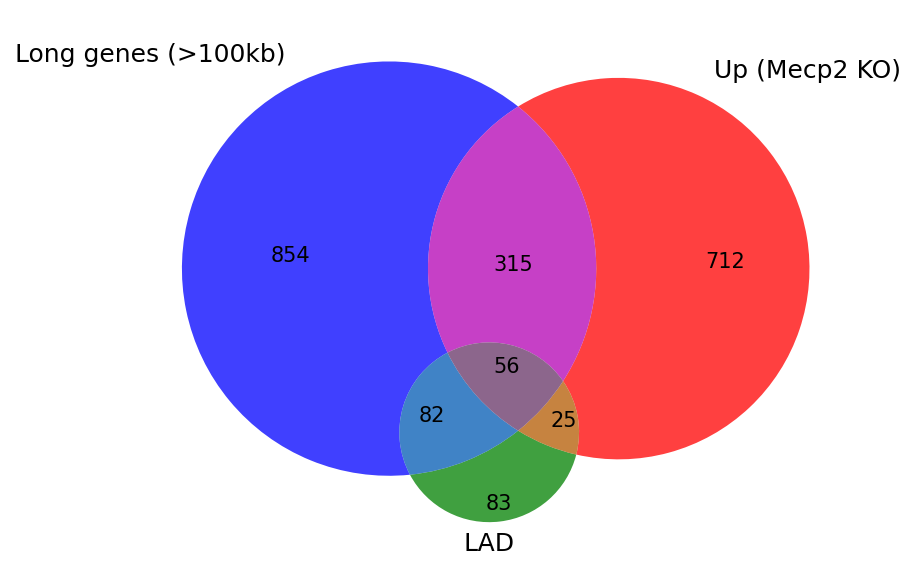

In [139]:
ABC = np.intersect1d(np.intersect1d(long_var_ids, up_mecp2_var_ids), lad_var_ids_mecp2).size
AB = np.intersect1d(long_var_ids, up_mecp2_var_ids).size - ABC
AC = np.intersect1d(long_var_ids, lad_var_ids_mecp2).size - ABC
BC = np.intersect1d(up_mecp2_var_ids, lad_var_ids_mecp2).size - ABC
A = long_var_ids.size - AB - AC - ABC
B = up_mecp2_var_ids.size - AB - BC - ABC
C = lad_var_ids_mecp2.size - AC - BC - ABC

venn = venn3(subsets = (A, B, AB, C, AC, BC, ABC), 
      set_labels=['Long genes (>100kb)','Up (Mecp2 KO)','LAD'], set_colors=['b','r','g',], alpha=.75,)

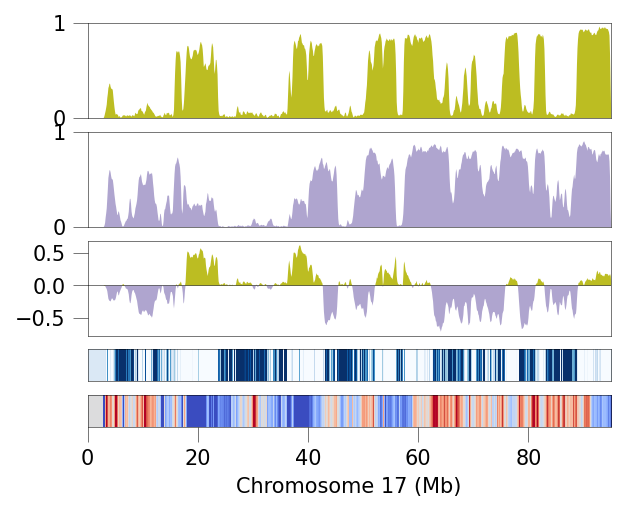

In [104]:
#smooth_stddev 125_000
chrom = '17'

binsize = 100_000
xaxis = np.arange(0,chromsizes[chrom],binsize) / 1e6

f, ax = plt.subplots(5, 1, figsize=(4.5,3.5), gridspec_kw={'height_ratios':[.6,.6,.6,.2,.2,]})

cell_type0 = 'esc'
y0 = cf_dict_100kb[cell_type0][chrom]
ax[0].fill_between(xaxis, y0, color=cell_type_colors[cell_type0], lw=0)

cell_type1 = 'migrating_neurons'
y1 = cf_dict_100kb[cell_type1][chrom]
ax[1].fill_between(xaxis, y1, color=cell_type_colors[cell_type1], lw=0)

X = (y0 - y1) 
X[X < 0] = 0
ax[2].fill_between(xaxis, 
                   X, 
                   lw=0,
                   color=cell_type_colors[cell_type0]
                  )
X = (y0 - y1) 
X[X > 0] = 0
ax[2].fill_between(xaxis, 
                   X, 
                   lw=0,
                   color=cell_type_colors[cell_type1]
                  )
ax[2].axhline(0, lw=.25, color='k')

k = 'npc'
X = m5c_100kb[k][chrom].reshape(1,-1)
p = np.percentile(X, 99.9)
X[X > p] = p
pcf1 = ax[3].pcolorfast(xaxis, 
                        [0,1], 
                        X, 
                        cmap='Blues', 
                        vmin=-.05,
                        vmax=.3
)

X = gaussian_filter(oe_chip_100kb_mean[k][chrom], 1).reshape(1,-1)
X[X < .101] = 1
pcf1 = ax[4].pcolorfast(xaxis, [0,1], X, cmap='coolwarm', vmin=.7, vmax=1.3)

ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

ax[2].margins(x=0)

for i in [0,1]:
    ax[i].margins(x=0)
    ax[i].set_ylim(0,1)
    ax[i].set_yticks([0,1])
for i in range(ax.size-1):
    ax[i].set_xticks([])
for i in (3,4):
    ax[i].set_yticks([])

Text(0.5, 1.0, 'MeCP2')

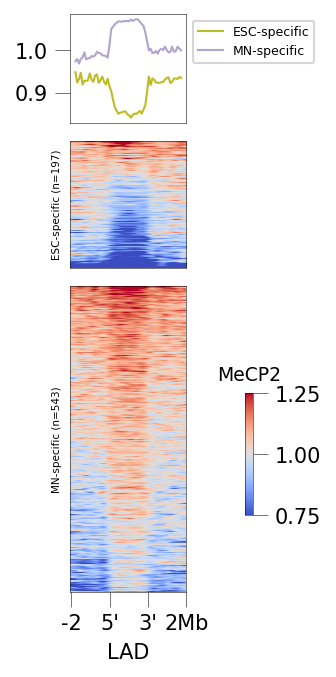

In [166]:
window = 2_000_000
data = oe_chip_100kb_mean

regions_dict = {
                'ESC-specific':esc_coord,
                'MN-specific':mn_coord
}
nregions = np.array([regions_dict[k].shape[0] for k in regions_dict])
height_ratios = np.r_[.25, nregions / nregions.sum()]

f, ax = plt.subplots(len(regions_dict) + 1, 
                     1, 
                     figsize=(1,5), 
                     gridspec_kw={'height_ratios':height_ratios,'hspace':.1}
)

for i,k in enumerate(regions_dict):
    regions = regions_dict[k]
    a2d, bounds = scct.scale_regions(regions, data, 100_000, window)
    a2d = a2d[bounds]
    a = a2d.mean(0)
    a2d = gaussian_filter(a2d, 1.25)

    pad = a2d.shape[1] // 3
    argsort = np.argsort(a2d[:,pad:pad*2].mean(1))
    argsort = np.argsort(a2d.mean(1))
    a2d = a2d[argsort][30:]
    
    ax[0].plot(a, 
               lw=1,
               label=k,
               color=cell_type_colors[['esc','migrating_neurons'][i]]
    )
    im = ax[i+1].imshow(a2d, 
                 aspect='auto', 
                 origin='lower', 
                 cmap='coolwarm',
                 vmin=.75, 
                 vmax=1.25
    )
    if i < len(regions_dict):
        ax[i].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_ylabel(f'{k} (n={a2d.shape[0]})', fontsize=5)
        
ax[-1].set_xticks(np.arange(0,pad*4,pad),[-2,"5'","3'",'2Mb'])
ax[-1].set_xlabel('LAD')
ax[0].legend(prop={'size':6}, bbox_to_anchor=(1,1))

axins = inset_axes(ax[-1],
   width="5%",  # width = 5% of parent_bbox width
   height="40%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.5, .25, 1.5, 1),
   bbox_transform=ax[-1].transAxes,
   borderpad=0,
   )
cbar = f.colorbar(im, ax=ax[-1], cax=axins)
cbar.ax.set_title(f'MeCP2', fontsize=9)

### 5mCA

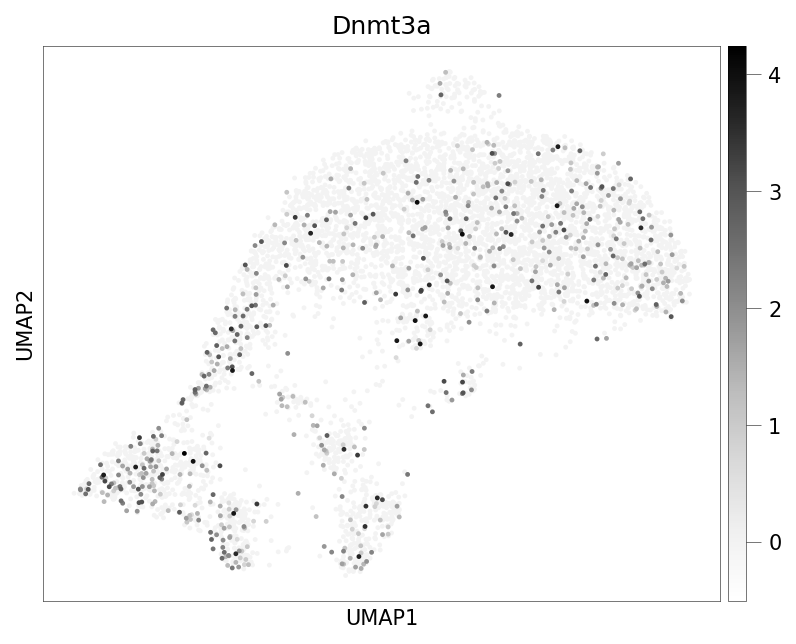

In [154]:
sc.pl.umap(adata, 
            color='Dnmt3a',
            cmap='Greys',
            vmin=-.5,
            layer='count_abundance_genes_from_celseq2_data',
)

[Text(0, 0, '-100'),
 Text(100, 0, 'TSS'),
 Text(200, 0, 'TES'),
 Text(300, 0, '100Kb')]

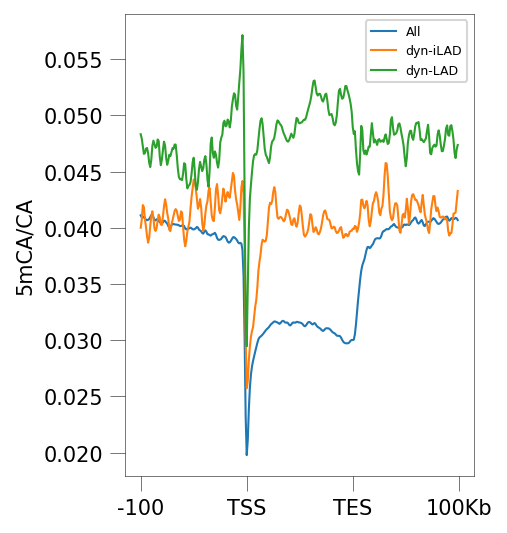

In [157]:
window = 100_000

f, ax = plt.subplots(figsize=(3,4))

sample = 'mCA/CA'

labels = ['All','dyn-iLAD','dyn-LAD']
for i,gene_ids in enumerate([deseq_mecp2.index,ilad_gene_ids,lad_gene_ids]):
    regions = gtf.loc[gene_ids,['Chromosome','Start','End']].values
    strand = gtf.loc[gene_ids,'Strand'].values

    a2d, bounds = scct.scale_regions(regions, bs_norm[sample], 1_000, window, strand=strand)
    a2d = gaussian_filter(a2d[bounds], sigma=1)
    
    
    ax.plot(a2d.mean(0), label=f"{labels[i]}", lw=1)
    
ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_ylabel('5mCA/CA')
ax.set_xticks([0,100,200,300])
ax.set_xticklabels([-100,'TSS','TES','100Kb'])